### Подключение библиотек и скриптов

In [11]:
!pip install LightFM

In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72.5% !important; }</style>"))

In [61]:
import pandas as pd
import numpy as np

from scipy import sparse
from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Пути к директориям и файлам

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
# links_path = '../data/links.csv'
movies_path = '/content/gdrive/MyDrive/Colab Notebooks/my_projects/data/movies.csv'
ratings_path = '/content/gdrive/MyDrive/Colab Notebooks/my_projects/data/ratings.csv'
# tags_path = '../data/tags.csv'

### Загрузка данных

In [18]:
# links_ds = pd.read_csv(links_path)
movies_ds = pd.read_csv(movies_path)
ratings_ds = pd.read_csv(ratings_path)
# tags_ds = pd.read_csv(tags_path)

### Изучение датасета

In [19]:
movies_ds.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
movies_ds.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [21]:
movies_ds.title.nunique()

9737

In [22]:
movies_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [23]:
ratings_ds.head()

,userId,movieId,rating,timestamp
0,1,1,4.00000,964982703
1,1,3,4.00000,964981247
2,1,6,4.00000,964982224
3,1,47,5.00000,964983815
4,1,50,5.00000,964982931


In [24]:
ratings_ds.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.00000,1493848402
100832,610,168248,5.00000,1493850091
100833,610,168250,5.00000,1494273047
100834,610,168252,5.00000,1493846352
100835,610,170875,3.00000,1493846415


In [25]:
ratings_ds.userId.nunique()

610

In [26]:
ratings_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


### Количественные переменные

In [27]:
movies_ds.describe()

,movieId
count,9742.00000
mean,42200.35362
std,52160.49485
min,1.00000
25%,3248.25000
50%,7300.00000
75%,76232.00000
max,193609.00000


In [28]:
ratings_ds.describe()

,userId,movieId,rating,timestamp
count,100836.00000,100836.00000,100836.00000,100836.00000
mean,326.12756,19435.29572,3.50156,1205946087.36847
std,182.61849,35530.98720,1.04253,216261035.99513
min,1.00000,1.00000,0.50000,828124615.00000
25%,177.00000,1199.00000,3.00000,1019123866.00000
50%,325.00000,2991.00000,3.50000,1186086662.00000
75%,477.00000,8122.00000,4.00000,1435994144.50000
max,610.00000,193609.00000,5.00000,1537799250.00000


###  Обработка выбросов и пропусков

In [29]:
movies_ds.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [30]:
ratings_ds.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

### Работа с признаками

In [31]:
data = pd.merge(movies_ds, ratings_ds, on='movieId')
data.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.00000,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.00000,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.50000,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.50000,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.50000,1305696483


In [32]:
# drop 'timestamp'
data = data[['userId','movieId', 'title', 'genres', 'rating']]

data.sort_values(['userId', 'movieId'], inplace=True)

data.reset_index(drop=True, inplace=True)

In [33]:
data.head()

,userId,movieId,title,genres,rating
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.00000
1,1,3,Grumpier Old Men (1995),Comedy|Romance,4.00000
2,1,6,Heat (1995),Action|Crime|Thriller,4.00000
3,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.00000
4,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.00000


In [34]:
data.tail()

,userId,movieId,title,genres,rating
100831,610,166534,Split (2017),Drama|Horror|Thriller,4.00000
100832,610,168248,John Wick: Chapter Two (2017),Action|Crime|Thriller,5.00000
100833,610,168250,Get Out (2017),Horror,5.00000
100834,610,168252,Logan (2017),Action|Sci-Fi,5.00000
100835,610,170875,The Fate of the Furious (2017),Action|Crime|Drama|Thriller,3.00000


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   title    100836 non-null  object 
 3   genres   100836 non-null  object 
 4   rating   100836 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


### Визуализация данных

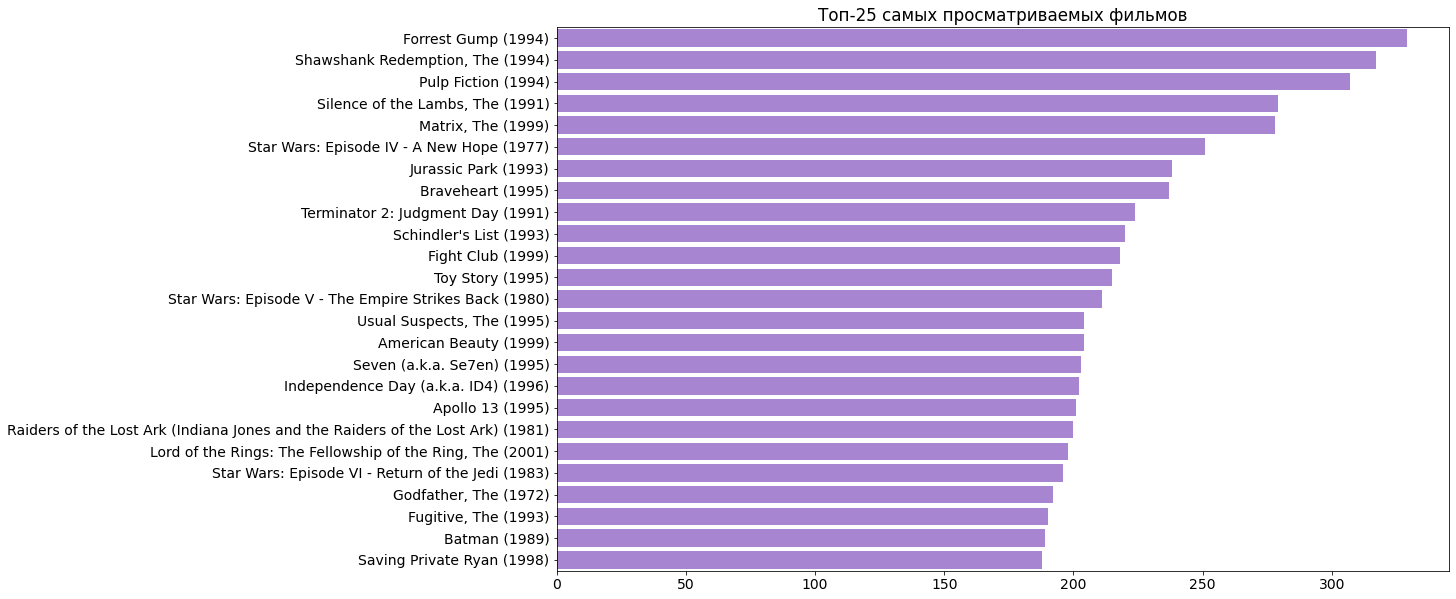

In [36]:
movie_raiting = data.groupby('title')['title'].count().sort_values(ascending=False).head(25)

plt.figure(figsize=(16, 10))
sns.barplot(y = movie_raiting.index, x = movie_raiting.values, color='#a678de')

plt.ylabel('')
plt.title('Топ-25 самых просматриваемых фильмов')
plt.show()

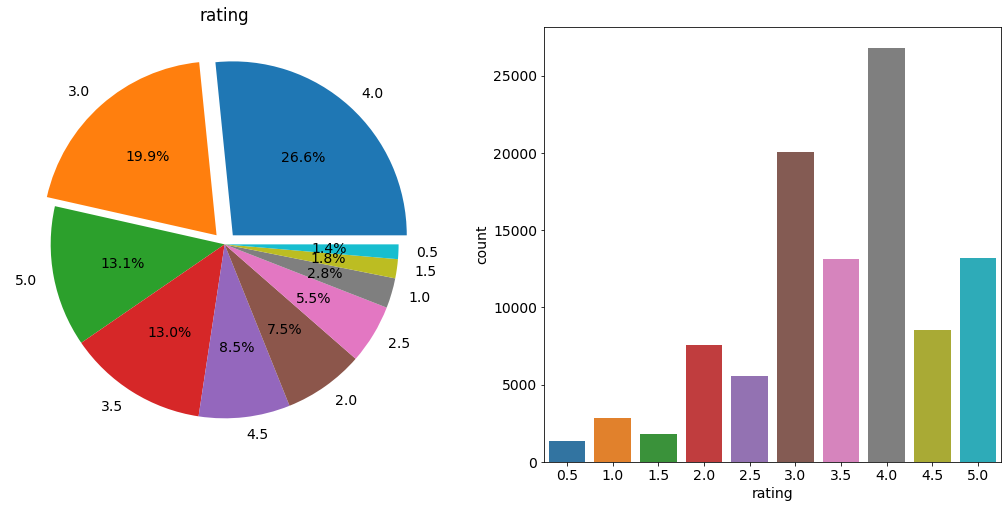

In [37]:
f, ax=plt.subplots(1, 2, figsize=(18, 8))
explode = (0.07, 0.07, 0, 0, 0, 0, 0, 0, 0, 0)
data['rating'].value_counts().plot.pie(explode=explode, autopct='%1.1f%%', ax=ax[0])
ax[0].set_title('rating')
ax[0].set_ylabel('')
sns.countplot('rating', data=data, ax=ax[1])
plt.show()

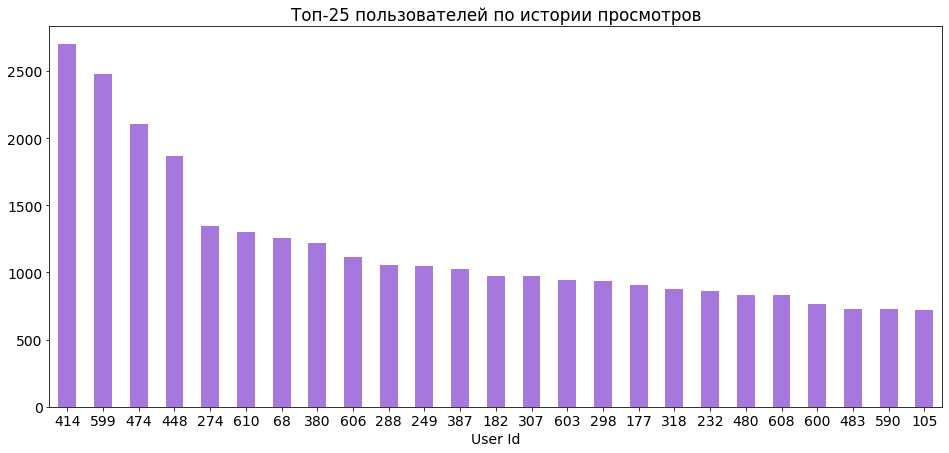

In [38]:
user_rating = data.groupby('userId')['title'].count().sort_values(ascending=False).head(25)

plt.figure(figsize=(16, 7))
user_rating.plot(kind='bar', color='#a678de')
plt.title('Топ-25 пользователей по истории просмотров')
plt.xlabel('User Id')
plt.xticks(rotation=0)
plt.show()

### Popularity-based recommendation

In [39]:
def popularity_recommendation(data, n):
    """Топ-n популярных фильмов"""
    
    movie_raiting = data.groupby('title')['title'].count().sort_values(ascending=False).head(n)
#     recs = movie_raiting.index
    recs = movie_raiting
    
#     return recs.tolist()
    return recs

In [40]:
%%time
popular_recs = popularity_recommendation(data, n=25)

CPU times: user 27.4 ms, sys: 752 µs, total: 28.1 ms
Wall time: 32.4 ms


In [41]:
popular_recs

title
Forrest Gump (1994)                                                               329
Shawshank Redemption, The (1994)                                                  317
Pulp Fiction (1994)                                                               307
Silence of the Lambs, The (1991)                                                  279
Matrix, The (1999)                                                                278
Star Wars: Episode IV - A New Hope (1977)                                         251
Jurassic Park (1993)                                                              238
Braveheart (1995)                                                                 237
Terminator 2: Judgment Day (1991)                                                 224
Schindler's List (1993)                                                           220
Fight Club (1999)                                                                 218
Toy Story (1995)                                

### LightFM

In [42]:
def create_interaction_matrix(df,user_col, item_col, rating_col, norm= False, threshold = None):
    '''
    Function to create an interaction matrix dataframe from transactional type interactions
    Required Input -
        - df = Pandas DataFrame containing user-item interactions
        - user_col = column name containing user's identifier
        - item_col = column name containing item's identifier
        - rating col = column name containing user feedback on interaction with a given item
        - norm (optional) = True if a normalization of ratings is needed
        - threshold (required if norm = True) = value above which the rating is favorable
    Expected output - 
        - Pandas dataframe with user-item interactions ready to be fed in a recommendation algorithm
    '''
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [43]:
interactions = create_interaction_matrix(df = ratings_ds,
                                         user_col = 'userId',
                                         item_col = 'movieId',
                                         rating_col = 'rating')

In [44]:
interactions.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,57,58,60,61,62,63,64,65,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,85,86,87,88,89,92,93,94,95,96,97,99,100,101,102,103,104,105,106,107,108,110,111,112,113,116,117,118,119,121,122,123,125,126,128,129,132,135,137,140,141,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,168,169,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185,186,187,188,189,190,191,193,194,195,196,198,199,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,222,223,224,225,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,265,266,267,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,287,288,...,170401,170411,170551,170597,170697,170705,170777,170813,170817,170827,170837,170875,170897,170907,170937,170939,170945,170957,170993,171011,171023,171251,171495,171631,171695,171701,171749,171751,171759,171763,171765,171811,171867,171891,171917,172013,172215,172229,172233,172253,172321,172461,172497,172547,172577,172583,172585,172587,172589,172591,172637,172705,172793,172825,172875,172881,172887,172909,173145,173197,173205,173209,173235,173253,173255,173291,173307,173317,173351,173355,173535,173619,173751,173873,173925,173941,173963,174045,174053,174055,174141,174403,174479,174551,174681,174727,174737,174815,174909,175197,175199,175293,175303,175387,175397,175401,175431,175435,175475,175485,175569,175577,175585,175661,175693,175705,175707,175743,175781,176051,176101,176329,176371,176389,176413,176415,176419,176423,176579,176601,176621,176751,176805,176935,177185,177285,177593,177615,177763,177765,177939,178061,178111,178129,178323,178613,178615,178827,179053,179073,179119,179133,179135,179211,179401,179427,179491,179511,179709,179749,179813,179815,179817,179819,179953,180031,180045,180095,180231,180263,180265,180297,180497,180777,180985,180987,181065,181139,181315,181413,181659,181719,182293,182297,182299,182639,182715,182727,182731,182749,182793,182823,183011,183197,183199,183227,183295,183301,183317,183611,183635,183897,183911,183959,184015,184053,184245,184253,184257,184349,184471,184641,184721,184791,184931,184987,184997,185029,185031,185033,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.00000,0.00000,4.00000,0.00000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,0.00000,0.00000,5.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0

In [50]:
def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input - 
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [51]:
def create_item_dict(df, id_col, name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input - 
        - df = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

In [52]:
# Create User Dict
user_dict = create_user_dict(interactions=interactions)
# Create Item dict
movies_dict = create_item_dict(df = movies_ds,
                               id_col = 'movieId',
                               name_col = 'title')

In [53]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30, n_jobs = 4):
    '''
    Function to run matrix-factorization algorithm
    Required Input -
        - interactions = dataset create by create_interaction_matrix
        - n_components = number of embeddings you want to create to define Item and user
        - loss = loss function other options are logistic, brp
        - epoch = number of epochs to run 
        - n_jobs = number of cores used for execution 
    Expected Output  -
        Model - Trained model
    '''
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

In [54]:
mf_model = runMF(interactions = interactions,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [55]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input - 
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - threshold = value above which the rating is favorable in new interaction matrix
        - nrec_items = Number of output recommendation needed
    Expected Output - 
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index) \
                                 .sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list

In [56]:
## Calling 10 movie recommendation for user id 77
rec_list = sample_recommendation_user(model = mf_model, 
                                      interactions = interactions, 
                                      user_id = 77, 
                                      user_dict = user_dict,
                                      item_dict = movies_dict, 
                                      threshold = 4,
                                      nrec_items = 10,
                                      show = True)

Known Likes:
1- Dark Knight, The (2008)
2- Batman Begins (2005)
3- Incredibles, The (2004)
4- Spider-Man 2 (2004)
5- Lord of the Rings: The Return of the King, The (2003)
6- Lord of the Rings: The Two Towers, The (2002)
7- Harry Potter and the Chamber of Secrets (2002)
8- Star Wars: Episode II - Attack of the Clones (2002)
9- Spider-Man (2002)
10- Lord of the Rings: The Fellowship of the Ring, The (2001)
11- Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
12- Gladiator (2000)
13- Matrix, The (1999)
14- Star Wars: Episode VI - Return of the Jedi (1983)
15- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
16- Star Wars: Episode V - The Empire Strikes Back (1980)
17- Star Wars: Episode IV - A New Hope (1977)

 Recommended Items:
1- Fight Club (1999)
2- Shrek (2001)
3- Shawshank Redemption, The (1994)
4- Finding Nemo (2003)
5- Forrest Gump (1994)
6- Memento (2000)
7- Pirates of the Caribbean: The Curse of the Black Pearl (2003)
8- Kill Bill: Vol. 1 (20

### Predict Model

In [57]:
def sample_recommendation_item(model, interactions, item_id, user_dict, item_dict, number_of_user):
    '''
    Funnction to produce a list of top N interested users for a given item
    Required Input -
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - item_id = item ID for which we need to generate recommended users
        - user_dict =  Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - number_of_user = Number of users needed as an output
    Expected Output -
        - user_list = List of recommended users 
    '''
    n_users, n_items = interactions.shape
    x = np.array(interactions.columns)
    scores = pd.Series(model.predict(np.arange(n_users), np.repeat(x.searchsorted(item_id),n_users)))
    user_list = list(interactions.index[scores.sort_values(ascending=False).head(number_of_user).index])
    return user_list 

In [58]:
sample_recommendation_item(model = mf_model,
                           interactions = interactions,
                           item_id = 1,
                           user_dict = user_dict,
                           item_dict = movies_dict,
                           number_of_user = 15)

[557, 399, 494, 569, 379, 173, 81, 126, 439, 394, 340, 347, 463, 176, 77]

In [59]:
def create_item_emdedding_distance_matrix(model, interactions):
    '''
    Function to create item-item distance embedding matrix
    Required Input -
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
    Expected Output -
        - item_emdedding_distance_matrix = Pandas dataframe containing cosine distance matrix b/w items
    '''
    df_item_norm_sparse = sparse.csr_matrix(model.item_embeddings)
    similarities = cosine_similarity(df_item_norm_sparse)
    item_emdedding_distance_matrix = pd.DataFrame(similarities)
    item_emdedding_distance_matrix.columns = interactions.columns
    item_emdedding_distance_matrix.index = interactions.columns
    return item_emdedding_distance_matrix

In [62]:
## Creating item-item distance matrix
item_item_dist = create_item_emdedding_distance_matrix(model = mf_model, interactions = interactions)
## Checking item embedding distance matrix
item_item_dist.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,57,58,60,61,62,63,64,65,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,85,86,87,88,89,92,93,94,95,96,97,99,100,101,102,103,104,105,106,107,108,110,111,112,113,116,117,118,119,121,122,123,125,126,128,129,132,135,137,140,141,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,168,169,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185,186,187,188,189,190,191,193,194,195,196,198,199,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,222,223,224,225,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,265,266,267,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,287,288,...,170401,170411,170551,170597,170697,170705,170777,170813,170817,170827,170837,170875,170897,170907,170937,170939,170945,170957,170993,171011,171023,171251,171495,171631,171695,171701,171749,171751,171759,171763,171765,171811,171867,171891,171917,172013,172215,172229,172233,172253,172321,172461,172497,172547,172577,172583,172585,172587,172589,172591,172637,172705,172793,172825,172875,172881,172887,172909,173145,173197,173205,173209,173235,173253,173255,173291,173307,173317,173351,173355,173535,173619,173751,173873,173925,173941,173963,174045,174053,174055,174141,174403,174479,174551,174681,174727,174737,174815,174909,175197,175199,175293,175303,175387,175397,175401,175431,175435,175475,175485,175569,175577,175585,175661,175693,175705,175707,175743,175781,176051,176101,176329,176371,176389,176413,176415,176419,176423,176579,176601,176621,176751,176805,176935,177185,177285,177593,177615,177763,177765,177939,178061,178111,178129,178323,178613,178615,178827,179053,179073,179119,179133,179135,179211,179401,179427,179491,179511,179709,179749,179813,179815,179817,179819,179953,180031,180045,180095,180231,180263,180265,180297,180497,180777,180985,180987,181065,181139,181315,181413,181659,181719,182293,182297,182299,182639,182715,182727,182731,182749,182793,182823,183011,183197,183199,183227,183295,183301,183317,183611,183635,183897,183911,183959,184015,184053,184245,184253,184257,184349,184471,184641,184721,184791,184931,184987,184997,185029,185031,185033,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.00000,0.77417,0.40218,-0.01074,0.36915,0.59084,0.30010,-0.12684,-0.06473,0.78755,0.44022,0.29907,0.42845,0.21008,0.07140,0.62173,0.46389,0.19761,0.66415,0.22068,0.33947,0.31355,0.43413,0.50252,0.48589,0.08691,0.08896,0.14710,0.29163,0.04393,0.57836,0.70643,0.87205,0.51141,-0.03213,0.68100,0.18038,0.37190,0.12662,0.04594,0.44268,0.26609,-0.07933,0.81873,0.63095,-0.48268,0.72526,0.04165,-0.50338,-0.38279,-0.36428,-0.28724,0.45913,0.36902,-0.18319,0.66196,0.28278,-0.28738,0.11617,0.31707,-0.22845,0.40051,0.62270,0.10500,0.25498,0.40704,0.06342,0.03830,0.03336,-0.49187,-0.09442,-0.11777,-0.31912,0.04382,-0.13528,0.02962,0.16310,0.44429,-0.11591,0.11065,0.53970,0.11011,0.19435,0.19072,0.35646,-0.40104,-0.21769,-0.19653,-0.17017,0.63105,0.10468,-0.20115,0.66162,0.48274,-0.18005,0.60407,-0.33650,0.73660,0.52305,0.3386

In [63]:
def item_item_recommendation(item_emdedding_distance_matrix, item_id, 
                             item_dict, n_items = 10, show = True):
    '''
    Function to create item-item recommendation
    Required Input - 
        - item_emdedding_distance_matrix = Pandas dataframe containing cosine distance matrix b/w items
        - item_id  = item ID for which we need to generate recommended items
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - n_items = Number of items needed as an output
    Expected Output -
        - recommended_items = List of recommended items
    '''
    recommended_items = list(pd.Series(item_emdedding_distance_matrix.loc[item_id,:]. \
                                  sort_values(ascending = False).head(n_items+1). \
                                  index[1:n_items+1]))
    if show == True:
        print("Item of interest :{0}".format(item_dict[item_id]))
        print("Item similar to the above item:")
        counter = 1
        for i in recommended_items:
            print(str(counter) + '- ' +  item_dict[i])
            counter+=1
    return recommended_items

In [64]:
## Calling 10 recommended items for item id 
rec_list = item_item_recommendation(item_emdedding_distance_matrix = item_item_dist,
                                    item_id = 5378,
                                    item_dict = movies_dict,
                                    n_items = 10)

Item of interest :Star Wars: Episode II - Attack of the Clones (2002)
Item similar to the above item:
1- Minority Report (2002)
2- Star Wars: Episode III - Revenge of the Sith (2005)
3- Lord of the Rings: The Fellowship of the Ring, The (2001)
4- Spider-Man (2002)
5- A.I. Artificial Intelligence (2001)
6- X2: X-Men United (2003)
7- Matrix Reloaded, The (2003)
8- Terminator 3: Rise of the Machines (2003)
9- Signs (2002)
10- Unbreakable (2000)


### Save / Load Model

In [66]:
import pickle
   
with open('item_item_dist.pkl', 'wb') as f:
    pickle.dump(item_item_dist, f)